In [1]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt

In [2]:
with open("../../../data/train_test_split/test_folders.json", "r") as train_file:
    test_folders = json.load(train_file)

In [3]:
df = pd.read_csv('../../../data/base_models/gpt4/temperature7_eval.csv')
lisa_sheets = pd.read_csv('../../../data/lisa_sheets.csv')
df = pd.merge(df, lisa_sheets[['id', 'folder']], how='left', on='id')
df = df[df['folder'].isin(test_folders)]
df.head()

,id,mcq_json,rubric,question,option_a,option_b,option_c,option_d,correct_option,content_gpt,...,is_question,relevance,ambiguity,gpt_answer,disclosure,difficulty,min_distractor_quality,avg_distractor_quality,distractor_quality,folder
31,OIC-328-06-B,{'question': 'What is the primary objective of...,Management of costs,What is the primary objective of immobilisatio...,Improve joint function,Relieve joint pain,Immobilise a joint,Improve mobility,c,**Item_parent:** Non-drug therapies and medica...,...,True,0.752212,0.713278,c,False,5,1,2,3,IC-328
32,OIC-328-12-B,{'question': 'Which type of therapy is NOT rec...,Definition,Which type of therapy is NOT recognized or rei...,Thermal medicine,Hydrotherapy,Thalassotherapy,Functional rehabilitation,c,**Item_parent:** Non-drug therapies and medica...,...,True,0.753601,0.642196,c,True,2,2,3,3,IC-328
33,OIC-328-05-A,{'question': 'What is the primary purpose of o...,Definition,What is the primary purpose of orthosis in med...,To treat injuries after trauma or surgery.,To provide stabilization and correction.,To enhance athletic performance.,To replace lost limbs.,b,**Item Parent:** Non-drug therapies and medica...,...,True,0.754027,0.643147,b,False,4,2,2,3,IC-328
34,OIC-328-08-A,{'question': 'Which component of a limb prosth...,Definition,Which component of a limb prosthesis is design...,End Effector,Socket,Aesthetic Trim,Intermediate Effector,b,**Item Parent:** Non-drug therapies and medica...,...,True,0.793626,0.528359,b,False,5,1,2,3,IC-328
35,OIC-328-02-A,{'question': 'What is the primary function of ...,Definition,What is the primary function of a medical devi...,To achieve its main effect through pharmacolog...,To standardize pricing and reimbursements,To serve a medical purpose without pharmacolog...,To replace human-origin products in medical tr...,c,**Item Parent:** Non-drug therapies and medica...,...,True,0.795150,0.631307,c,False,5,1,3,3,IC-328


In [4]:
len(df)

1524

In [5]:
df['correct_option'].unique()

array(['c', 'b', 'd', 'a', 'option_c', 'option_b', 'option_d', 'option_a'],
      dtype=object)

In [6]:
# normalize correct_option
df['correct_option'] = df['correct_option'].replace({'option_b': 'b', 'option_c': 'c', 'option_d': 'd', 'option_a': 'a'}) 

# Question mark

In [7]:
# We want to maximize 'True'
question_freqs = {
    'True': round(df['is_question'].sum()/ len(df) * 100, 2),
    'False': round((len(df) - df['is_question'].sum()) / len(df) * 100, 2)
}

question_freqs

{'True': np.float64(100.0), 'False': np.float64(0.0)}

# Negation

In [8]:
# We want to minimze 'True'
starts_with_negation_freqs = {
    'True': round(df['starts_with_negation'].sum() / len(df) * 100, 2),
    'False': round((len(df) - df['starts_with_negation'].sum()) / len(df) * 100, 2)
}

starts_with_negation_freqs

{'True': np.float64(0.0), 'False': np.float64(100.0)}

# Readability

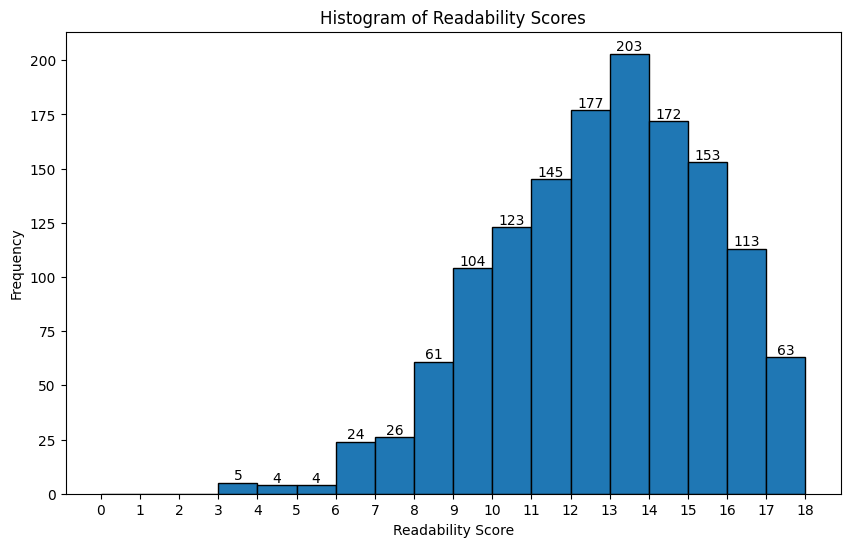

In [9]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['readability'], bins=range(0, 19, 1), edgecolor='black')

# Set x-axis ticks from 0 to 18
plt.xticks(range(0, 19))

# Add frequency labels on top of each bar where frequency > 0
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.show()

In [10]:
df['readability'].describe()

count    1524.000000
mean       13.531399
std         3.415035
min         3.653333
25%        11.255280
50%        13.450000
75%        15.640000
max        27.250000
Name: readability, dtype: float64

# Originality

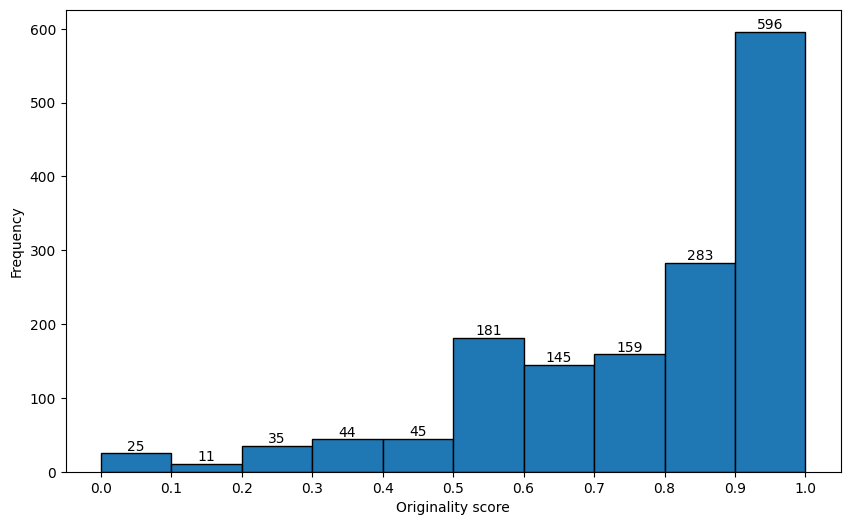

In [11]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['originality'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Originality score')
plt.ylabel('Frequency')
plt.show()

In [12]:
df['originality'].describe()

count    1524.000000
mean        0.779261
std         0.238452
min         0.000000
25%         0.666667
50%         0.833333
75%         1.000000
max         1.000000
Name: originality, dtype: float64

# Answer Length

In [13]:
option_cols = ['option_a', 'option_b', 'option_c', 'option_d']

# Create new columns with word counts for each option column
for col in option_cols:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))

In [14]:
def get_correct_option_rank(row):
    # Get the original word counts for each option
    counts = [
        row['option_a_word_count'],
        row['option_b_word_count'],
        row['option_c_word_count'],
        row['option_d_word_count']
    ]

    # Map correct_option letter to its index (0 for A, 1 for B, etc.)
    letter_to_index = {'A': 0, 'a':0, 'B': 1, 'b':1, 'C': 2, 'c':2, 'D': 3, 'd':3}
    correct_idx = letter_to_index[row['correct_option']]

    # Determine the word count of the correct option
    correct_count = counts[correct_idx]

    # Create an effective counts list:
    # For non-correct options, if their word count equals the correct option's word count,
    # treat them as if they had one extra word.
    effective_counts = []
    for i, count in enumerate(counts):
        if i != correct_idx and count == correct_count:
            effective_counts.append(count + 1)
        else:
            effective_counts.append(count)

    # Sort the option indices by descending effective count.
    ordering = sorted(range(4), key=lambda i: effective_counts[i], reverse=True)

    # Compute the rank as the 1-indexed position of the correct option in the ordering.
    rank = ordering.index(correct_idx) + 1
    return rank

In [15]:
def get_rank_distribution(df):
  rank_distribution = df['correct_option_rank'].value_counts().sort_index()
  rank_distribution = round(rank_distribution / len(df), 2) * 100

  plt.figure(figsize=(8, 6))
  plt.bar(rank_distribution.index, rank_distribution.values, color='skyblue', edgecolor='black')
  plt.xlabel('N (1 = Longest, 4 = Shortest)')
  plt.ylabel('Frequency, %')
  plt.title('How often the correct option is N`th longest')
  plt.xticks([1, 2, 3, 4])
  plt.show()

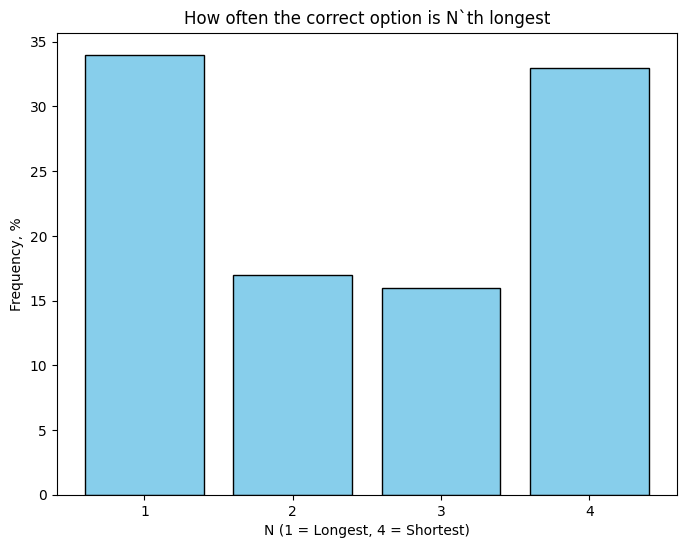

In [16]:
df['correct_option_rank'] = df.apply(get_correct_option_rank, axis=1)
get_rank_distribution(df)

# Disclosure

In [17]:
disclosure_freqs = {
    'True': round((df['disclosure'].sum() / len(df)) * 100, 2),
    'False': round((len(df) - df['disclosure'].sum()) / len(df) * 100, 2)
}

disclosure_freqs

{'True': np.float64(8.14), 'False': np.float64(91.86)}

# Relevance to the input material

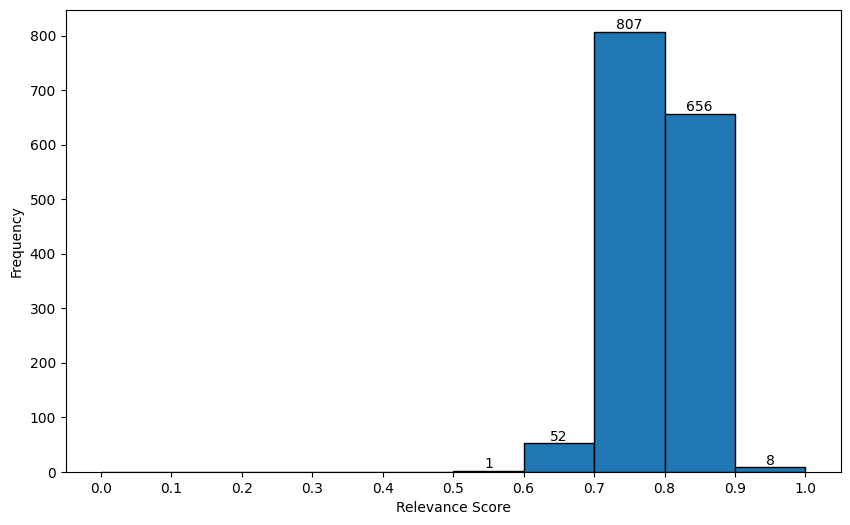

In [18]:
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['relevance'], bins=10, range=(0, 1), edgecolor='black')

plt.xticks([round(x * 0.1, 1) for x in range(11)])

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
                 ha='center', va='bottom')

plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

In [19]:
df['relevance'].describe()

count    1524.000000
mean        0.790286
std         0.046906
min         0.582201
25%         0.762888
50%         0.791566
75%         0.822383
max         0.935077
Name: relevance, dtype: float64

# Ambiguity (cosine similarity)

Text(0.5, 1.0, 'Distribution of Ambiguity')

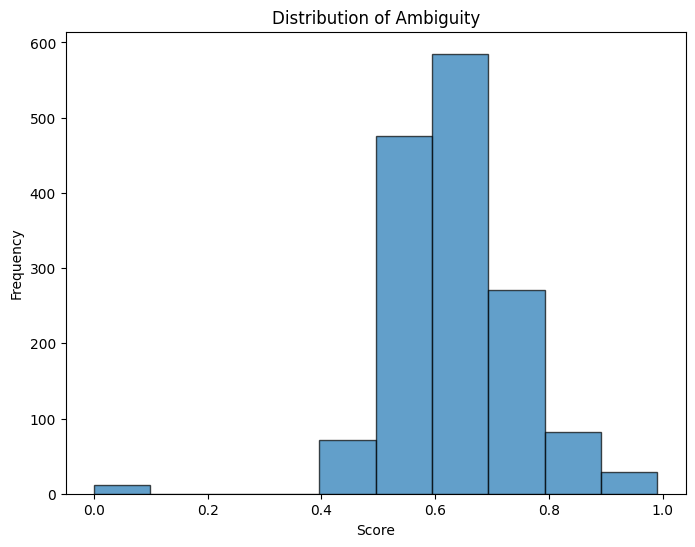

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(df['ambiguity'], bins=10, edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Ambiguity")

In [21]:
df['ambiguity'].describe()

count    1524.000000
mean        0.632963
std         0.110646
min         0.000000
25%         0.565556
50%         0.622396
75%         0.694010
max         0.991067
Name: ambiguity, dtype: float64

# Difficulty (judge LLM)

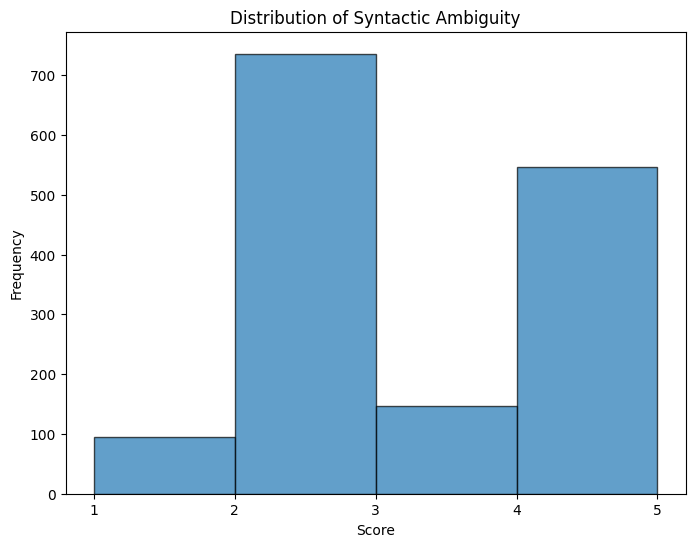

In [22]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['difficulty'], bins=np.arange(1, 6), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Syntactic Ambiguity")
plt.xticks(range(1, 6))

# Show the plot
plt.show()

In [23]:
df['difficulty'].describe()

count    1524.000000
mean        2.935039
std         1.280842
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: difficulty, dtype: float64

# Answerability
can judge model answer the generated question with context provided?

In [24]:
df['gpt_answer'].unique()

array(['c', 'b', 'd', 'a'], dtype=object)

In [25]:
df['correct_option'].unique()

array(['c', 'b', 'd', 'a'], dtype=object)

In [26]:
answerability_freqs = {
    'True': round((df['correct_option'] == df['gpt_answer']).sum() / len(df) * 100, 2), 
    'False': round((len(df) - (df['correct_option'] == df['gpt_answer']).sum()) / len(df) * 100, 2)
}

answerability_freqs

{'True': np.float64(99.67), 'False': np.float64(0.33)}

# Distractors Quality

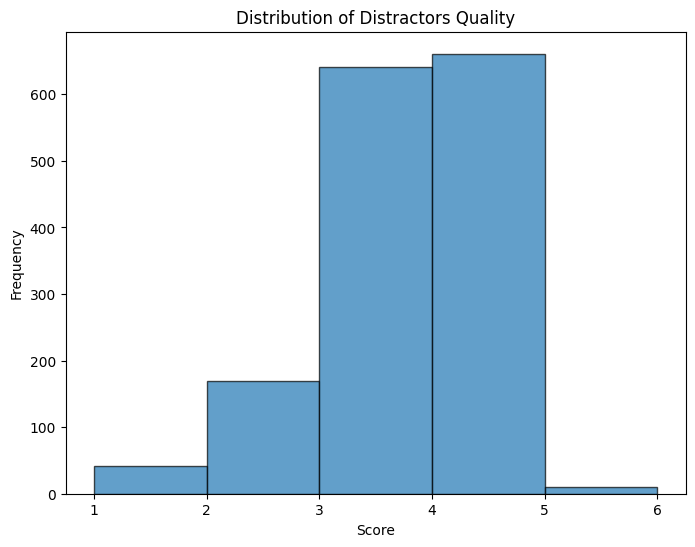

In [27]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.hist(df['distractor_quality'], bins=np.arange(1, 7), edgecolor='black', alpha=0.7)

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Distractors Quality")
plt.xticks(range(1, 7))

# Show the plot
plt.show()

In [28]:
distractors_quality = {
    'Good, %':  round(len(df[df['distractor_quality'] >= 4]) / len(df) * 100, 2),
    'Bad, %': round(len(df[df['distractor_quality'] < 4]) / len(df) * 100, 2),
}

distractors_quality

{'Good, %': 44.03, 'Bad, %': 55.97}